In [6]:
import numpy as np
import pandas as pd
import glob
import torch
import matplotlib.pyplot as plt
import random
import pickle
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from   sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler
#!{sys.executable} -m pip install scikit-learn-extra

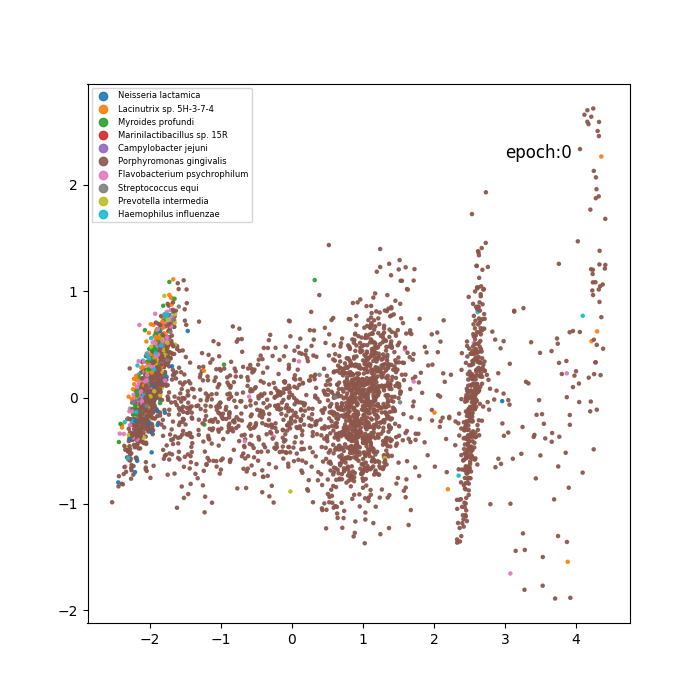

In [13]:
reference = '/mnt/data/CAMI/DNABERT/epoch0.png'

from IPython import display
display.Image(reference)

In [8]:
reference_path = '/mnt/data/CAMI/DNABERT/output/'

tensors = []
contig_names = []
for filename in glob.glob('/mnt/data/CAMI/DNABERT/output/*.pickle'):
    with open(filename, 'rb') as f:
        x = pickle.load(f)
        tensors.extend(list(x.values()))
        contig_names.extend(list(x.keys()))
concat_tensors = torch.cat(tensors,0)

RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradNestedTensor, UNKNOWN_TENSOR_TYPE_ID, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:5925 [kernel]
CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA.cpp:7100 [kernel]
QuantizedCPU: registered at /pytorch/build/aten/src/ATen/RegisterQuantizedCPU.cpp:641 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:10525 [kernel]
Autocast: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:254 [kernel]
Batched: registered at /pytorch/aten/src/ATen/BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [10]:
taxonomy = '/mnt/data/CAMI/data/short_read_oral/taxonomy.tsv'
contig_to_genome = '/mnt/data/CAMI/data/short_read_oral/reformatted_manually_combined_gsa_mapping.tsv'

contig_to_genome_df = pd.read_csv(contig_to_genome, sep='\t', header=None)
contig_to_genome_df = contig_to_genome_df.rename(columns={0: 'contig_name', 1: 'genome'})

taxonomy_df = pd.read_csv(taxonomy, sep='\t', header = None)
taxonomy_df = taxonomy_df.rename(columns={0: 'genome', 1: 'species', 2: 'genus'})

In [11]:
merged_df = pd.merge(contig_to_genome_df, taxonomy_df, how="left", on=["genome"])
merged_df

,contig_name,genome,2,3,4,species,genus
0,S13C144379,OTU_97.10732.1,CP014228.1,848814,849755,Actinomyces radicidentis,Actinomyces
1,S13C4155,OTU_97.27895.0,CP010906.1,758589,760618,Campylobacter jejuni,Campylobacter
2,S13C140957,OTU_97.37776.1,CP002094.1,2081039,2081268,Lactococcus lactis,Lactococcus
3,S13C24289,OTU_97.34522.1,AM295007.1,1679584,1680153,Streptococcus pyogenes,Streptococcus
4,S13C116303,OTU_97.23.0,LN831051.1,2043591,2043855,Streptococcus pneumoniae,Streptococcus
...,...,...,...,...,...,...,...
2964252,S8C75706,OTU_97.28883.0,CP000921.1,1377239,1379025,Streptococcus pneumoniae,Streptococcus
2964253,S8C46428,OTU_97.39134.0,FM204883.1,609148,609430,Streptococcus equi,Streptococcus
2964254,S8C149508,OTU_97.39522.0,CP012075.1,150371,152780,Prevotella fusca,Prevotella
2964255,S8C112712,OTU_97.28231.0,HE858529.1,2154398,2155309,Streptococcus dysgalactiae,Streptococcus


In [12]:
merged_df_sample_6 = merged_df[merged_df['contig_name'].str.startswith('S6C')]
merged_df_sample_6

,contig_name,genome,2,3,4,species,genus
2347908,S6C18400,OTU_97.21068.0,CP007205.1,462613,462958,Pasteurella multocida,Pasteurella
2347909,S6C5363,OTU_97.360.0,CP011378.1,2237375,2237753,Moraxella bovoculi,Moraxella
2347910,S6C5964,OTU_97.44228.0,AL732656.1,1657415,1679815,Streptococcus agalactiae,Streptococcus
2347911,S6C25085,OTU_97.38344.1,AE015924.1,56405,56679,Porphyromonas gingivalis,Porphyromonas
2347912,S6C26340,OTU_97.28595.0,CP002633.1,1539662,1603370,Streptococcus suis,Streptococcus
...,...,...,...,...,...,...,...
2386722,S6C840,OTU_97.23623.1,CP016670.1,544757,545197,Neisseria meningitidis,Neisseria
2386723,S6C3157,OTU_97.26568.0,CP010905.2,1800242,1800507,Clostridioides difficile,Clostridioides
2386724,S6C36073,OTU_97.2213.1,HE613569.1,1297768,1297975,Streptococcus macedonicus,Streptococcus
2386725,S6C38150,OTU_97.17212.1,CP009421.1,413972,414121,Neisseria meningitidis,Neisseria


In [7]:
contig_lengths = "/mnt/data/CAMI/DNABERT/contig_lengths.pickle"
with open(contig_lengths,'rb') as f:
    contig_lengths = pickle.load(f)
    
contig_lengths = {k[1:]: v for k, v in contig_lengths.items()}
merged_df["contig_lengths"] = merged_df["contig_name"].map(contig_lengths)
merged_df

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/CAMI/DNABERT/contig_lengths.pickle'

In [ ]:
contig_name_to_idx = {v[1:]: i for i, v in enumerate(contig_names)}
merged_df["contig_idx"] = merged_df["contig_name"].apply(lambda x: contig_name_to_idx.get(x))
non_aligned = ~merged_df["contig_idx"].isnull()
aligned_tensor_df = merged_df[non_aligned]
aligned_tensor_df

In [ ]:
column = aligned_tensor_df['contig_lengths']
max_value = column.max()
print(max_value)

In [ ]:
aligned_tensor_index_df = aligned_tensor_df.astype({"contig_idx": int})
aligned_tensor_index_df = aligned_tensor_index_df.set_index("contig_idx").sort_index()
aligned_tensor_index_df

In [ ]:
# Filter all contigs > 512

print(len(aligned_tensor_index_df))
filtered_512_df = aligned_tensor_index_df[aligned_tensor_index_df["contig_lengths"] < 512]
print(len(filtered_512_df))

In [ ]:
def plot_kmeans():
    all_concat_np = concat_tensors.detach().numpy()
    
    pca = PCA(n_components=2)
    pca.fit(all_concat_np)
    projection = pca.transform(all_concat_np)
    
    
    from sklearn.cluster import KMeans
    wcss = []
    for i in range(100,700):
        kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=None)
        kmeans_pca.fit(projection)
        wcss.append(kmeans_pca.inertia_)

    plt.plot(range(100,700), wcss, marker = 'o', linestyle = '--')
    
    #kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state=None).fit(projection)
    #print(kmeans_pca.cluster_centers_)
    #print(kmeans_pca.inertia_)
    
    #from sklearn_extra.cluster import KMedoids
    #ss = []
    #for i in range(1,10):
        #kmedoids_pca = KMedoids(n_clusters=2, random_state=0)
        #kmedoids_pca.fit(projection)
        #ss.append(kmedoids_pca.inertia_)
    
    #plt.plot(range(1,10), ss, marker = 'o', linestyle = '--')

    #kmedoids_pca = KMedoids(n_clusters=2, random_state=0).fit(projection)
    #print(kmedoids_pca.cluster_centers_)
    #print(kmedoids_pca.inertia_)
    
plot_kmeans()

In [8]:
MIN_SIZE_OF_GROUP = 100
NUM_TO_GROUPS_TO_PLOT = 10
GROUP_KEY = "species"

genome_group_indices = []
i = 0
groups = list(filtered_512_df.groupby(GROUP_KEY))
random.shuffle(groups)
for x_name, x in groups:
    if i >= 10:
        break
        
    group_size = len(x)
    if group_size < MIN_SIZE_OF_GROUP or group_size > 1000:
        continue
        
    genome_group_indices.extend(x.index.tolist())
    i += 1

print(len(genome_group_indices))

NameError: name 'filtered_512_df' is not defined

In [9]:
def plot_pca():
    all_concat_np = concat_tensors.detach().numpy()
    genome_group_np = all_concat_np[genome_group_indices]
    
    pca = PCA(n_components=2)
    pca.fit(genome_group_np)
    projection = pca.transform(genome_group_np)
    
    genome_to_color_id = {k: i for k, i in zip(filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique(), range(10))}
    print(genome_to_color_id.keys())
    targets = filtered_512_df.loc[genome_group_indices][GROUP_KEY].apply(lambda x: genome_to_color_id[x]).tolist()
    
    labels = filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique().tolist()
    print(labels)
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(projection[:, 0], projection[:, 1], alpha=0.9, s=5.0, c=targets, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=labels)
    
plot_pca()

NameError: name 'concat_tensors' is not defined

In [ ]:
def plot_kmeans():
    all_concat_np = concat_tensors.detach().numpy()
    genome_group_np = all_concat_np[genome_group_indices]
    
    pca = PCA(n_components=2)
    pca.fit(genome_group_np)
    projection = pca.transform(genome_group_np)
    
    
    from sklearn.cluster import KMeans
    wcss = []
    for i in range(1,10):
        kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=None)
        kmeans_pca.fit(projection)
        wcss.append(kmeans_pca.inertia_)

    plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')
    
    kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state=None).fit(projection)
    print(kmeans_pca.cluster_centers_)
    print(kmeans_pca.inertia_)
    
    from sklearn_extra.cluster import KMedoids
    ss = []
    for i in range(1,10):
        kmedoids_pca = KMedoids(n_clusters=2, random_state=0)
        kmedoids_pca.fit(projection)
        ss.append(kmedoids_pca.inertia_)
    
    plt.plot(range(1,10), ss, marker = 'o', linestyle = '--')

    kmedoids_pca = KMedoids(n_clusters=2, random_state=0).fit(projection)
    print(kmedoids_pca.cluster_centers_)
    print(kmedoids_pca.inertia_)
    
plot_kmeans()



In [ ]:
def plot_tsne():    
    all_concat_np = concat_tensors.detach().numpy()
    genome_group_np = all_concat_np[genome_group_indices]
    
    #NUM_SUBSAMPLE = 10000
    subsample_indices = list(range(len(genome_group_np)))
    #random.shuffle(subsample_indices)
    # subsample_indices =  subsample_indices[:NUM_SUBSAMPLE]
    
    subsampled_genome_groups_np = genome_group_np[subsample_indices]
    tsne = TSNE(n_components=2, perplexity=30)
    projection = tsne.fit_transform(subsampled_genome_groups_np)
    
    genome_to_color_id = {k: i for k, i in zip(filtered_512_df.loc[genome_group_indices].iloc[subsample_indices][GROUP_KEY].unique(), range(10))}
    targets = filtered_512_df.loc[genome_group_indices].iloc[subsample_indices][GROUP_KEY].apply(lambda x: genome_to_color_id[x]).tolist()
    labels = filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique().tolist()
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(projection[:, 0], projection[:, 1], alpha=0.9, s=3.0, c=targets, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=labels)

plot_tsne()

In [ ]:
import sys
import vamb

def create_contig_file_list(path_to_contig_file):
    contig_list = []
    with open(path_to_contig_file, 'r') as fp:
        lines = fp.readlines()
        for line in lines:
            line = line.rstrip()
            contig_list.append(line)
    return contig_list

mincontiglength=10
contig_file_list='/mnt/data/CAMI/vamb/workflow/contigs.txt'
file_list = create_contig_file_list(contig_file_list)

tnfs_per_fasta = []
contignames_per_fasta = []
for fasta in file_list:
    with vamb.vambtools.Reader(fasta, 'rb') as tnffile:
        tnfs, contignames, contiglengths = vamb.parsecontigs.read_contigs(tnffile, minlength=mincontiglength)
        tnfs_per_fasta.append(tnfs)
        contignames_per_fasta.extend(contignames)

tnfs_per_fasta = np.concatenate(tnfs_per_fasta)

In [ ]:
print(len(contignames_per_fasta))
print(len(tnfs))

In [ ]:
# contignames to be sorted like filtered_512_df

contig_name_to_idx = {v: i for i, v in enumerate(contignames_per_fasta)}
vamb_aligned_tensor_df["contig_vamb_idx"] = aligned_tensor_df["contig_name"].map(contig_name_to_idx)
vamb_aligned_tensor_df

In [ ]:
non_aligned = ~vamb_aligned_tensor_df["contig_vamb_idx"].isnull()
vam_aligned_reset_tensor_df = vamb_aligned_tensor_df[non_aligned]
vamb_aligned_tensor_df = vamb_aligned_tensor_df.astype({"contig_vamb_idx": int})
vamb_aligned_tensor_df = vamb_aligned_tensor_df.astype({"contig_idx": int})
vamb_aligned_tensor_df

In [ ]:
vamb_aligned_tensor_df_2 = vamb_aligned_tensor_df.set_index("contig_idx").sort_index()
vamb_aligned_tensor_df_2

In [ ]:
print(len(vamb_aligned_tensor_df))
vamb_filtered_512_df = vamb_aligned_tensor_df_2[vamb_aligned_tensor_df_2["contig_lengths"] < 512]

print(len(vamb_filtered_512_df))
vamb_filtered_512_df

In [ ]:
MIN_SIZE_OF_GROUP = 100
MAX_SIZE_OF_GROUP = 1000
NUM_TO_GROUPS_TO_PLOT = 10
GROUP_KEY = "species"

genome_group_indices = []
i = 0
groups = list(vamb_filtered_512_df.groupby(GROUP_KEY))
random.shuffle(groups)
for x_name, x in groups:
    if i >= 10:
        break
        
    group_size = len(x)
    if group_size < MIN_SIZE_OF_GROUP or group_size > MAX_SIZE_OF_GROUP:
        continue
        
    genome_group_indices.extend(x.index.tolist())
    i += 1

print(len(genome_group_indices))

In [ ]:
def plot_pca_matrix(matrix):
    pca = PCA(n_components=2)
    pca.fit(matrix)
    projection = pca.transform(matrix)
    
    genome_to_color_id = {k: i for k, i in zip(vamb_filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique(), range(10))}
    targets = vamb_filtered_512_df.loc[genome_group_indices][GROUP_KEY].apply(lambda x: genome_to_color_id[x]).tolist()
    labels = vamb_filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique().tolist()
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(projection[:, 0], projection[:, 1], alpha=0.9, s=5.0, c=targets, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=labels)

tnf_matrix = tnfs_per_fasta[vamb_filtered_512_df.loc[genome_group_indices]["contig_vamb_idx"].tolist()]
plot_pca_matrix(tnf_matrix)

all_concat_np = concat_tensors.detach().numpy()
genome_group_np = all_concat_np[genome_group_indices]
plot_pca_matrix(genome_group_np)

tnf_matrix = (tnf_matrix) / (tnf_matrix.std())
genome_group_np = (genome_group_np) / (genome_group_np.std())

cat_tnf_dna = np.concatenate([genome_group_np, tnf_matrix], axis=-1)
plot_pca_matrix(cat_tnf_dna)

In [ ]:
def plot_tsne_matrix(matrix):    
    tsne = TSNE(n_components=2, perplexity=30)
    projection = tsne.fit_transform(matrix)
    
    genome_to_color_id = {k: i for k, i in zip(vamb_filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique(), range(10))}
    targets = vamb_filtered_512_df.loc[genome_group_indices][GROUP_KEY].apply(lambda x: genome_to_color_id[x]).tolist()
    labels = vamb_filtered_512_df.loc[genome_group_indices][GROUP_KEY].unique().tolist()
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(projection[:, 0], projection[:, 1], alpha=0.9, s=3.0, c=targets, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=labels)

tnf_matrix = tnfs_per_fasta[vamb_filtered_512_df.loc[genome_group_indices]["contig_vamb_idx"].tolist()]
plot_tsne_matrix(tnf_matrix)

all_concat_np = concat_tensors.detach().numpy()
genome_group_np = all_concat_np[genome_group_indices]
plot_tsne_matrix(genome_group_np)

tnf_matrix = (tnf_matrix) / (tnf_matrix.std())
genome_group_np = (genome_group_np) / (genome_group_np.std())
cat_tnf_dna = np.concatenate([genome_group_np, tnf_matrix], axis=-1)
plot_tsne_matrix(cat_tnf_dna)

In [ ]:
#torch.load('/mnt/data/CAMI/DNABERT/pretrained_models/4-new-12w-0/pytorch_model.bin', map_location=torch.device('cpu'))

In [ ]:
import torch 
from transformers import BertTokenizer, BertforSequenceClassification